El objetivo de este código es hacer la partición de los datos respetando la repetición de la que fueron obtenidos, e implementar un mlp.



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


In [2]:
#!pip install comet_ml
from comet_ml import Experiment
# import matplotlib.pyplot as plt
import numpy as np
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import joblib
# import seaborn as sns
import time

sys.path.append('/content/drive/My Drive/repo_tesis/lib')
import classes as cl

features = load("/content/drive/My Drive/repo_tesis/data/FEATURES_W200_I50.joblib")
label = load("/content/drive/My Drive/repo_tesis/data/label_W200_I50.joblib")

Voy a dividir los datos a mano de la siguiente forma.
Un sujeto repite cada gesto entre 5 y 6 veces. Voy a usar:
- Una repetición para test.
- Una para validacion.
- Las restantes para train.

En este sentido, voy a guardar los indices de label en listas distintas, para identificar luego que filas de FEATURES tengo que usar para cada conjunto de datos (train, val y test).

La implementación de esta idea parte del supuesto de que los gestos iguales estan agrupados, es decir, las repeticiones del mismo gesto son consecutivas. Esto para los gestos que no son reposo.

Para los gestos de reposo se va a hacer un trato diferenciado. Primero se va a hacer la partición sin ellos, y luego, cada repetición de reposo se va a incluir en el mismo conjunto de la repetición de gesto previa a ese reposo.

In [ ]:
label = np.array(label)

# Esto funciona porque los gestos iguales estan agrupados
# Hago un diff en el id del gesto para saber en que indices se cambia el gesto
# Calculo los indices de label que son ventanas de reposo para trabajar con ellas por separado
ind_reposo = np.where(label[:, 1]==0)[0]

# Calculo lo contrario ahora para facilitar obtener los labels de las ventanas con gestos
ind_gestos = np.where(label[:, 1]!=0)[0]

label_gestos = label[ind_gestos, :]

division_gestos = np.where(np.diff(label_gestos[:, 1])!=0)[0]

# Ahora hago un diff sobre la id de ventana para saber cuando cambia. Esto me va a servir para poder separarlo
# en train, val y test
division_id_ventanas = np.where(np.diff(label_gestos[:, 0])!=0)[0]

# Aca voy a guardar el id de la ventana
train = []
val = []
test = []

for i in range(len(division_gestos)+1):  #
    if i==len(division_gestos):
        ind_tope_ventana = np.max(label_gestos[:, 0])
        ind_inicio_ventana = label_gestos[division_gestos[-1], 0]

        # cantidad de repeticiones en el gesto actual (del sujeto actual)
        cant_ventanas = ind_tope_ventana - ind_inicio_ventana

    else:
        tope = division_gestos[i]   # este es limite con el proximo gesto

        if i==0:
            inicio = 0
            ind_inicio_ventana = 0
        else:
            inicio = division_gestos[i-1]
            ind_inicio_ventana = np.where(division_id_ventanas==inicio)[0][0]

        # busco en division_id_ventana cuantos elementos hay entre inicio y tope
        ind_tope_ventana = np.where(division_id_ventanas==tope)[0][0]

        # cantidad de repeticiones en el gesto actual (del sujeto actual)
        cant_ventanas = ind_tope_ventana - ind_inicio_ventana


    if i != 0:
        # sorteo las ventanas que van a cada grupo
        sorteo = np.random.permutation(cant_ventanas)
        sorteo += 1     # correccion de rango
    else:
        sorteo = np.random.permutation(cant_ventanas+1)
    # El primero va a test, el segundo a val y el resto a train
    test.append(ind_inicio_ventana + sorteo[0])
    val.append(ind_inicio_ventana + sorteo[1])
    for j in range(2, len(sorteo)):
        train.append(ind_inicio_ventana + sorteo[j])

A continuación se inserta un código de visualización. Fue usado para chequear que se estaba trabajando correctamente. Quizás pueda ser de utilidad en algún momento.

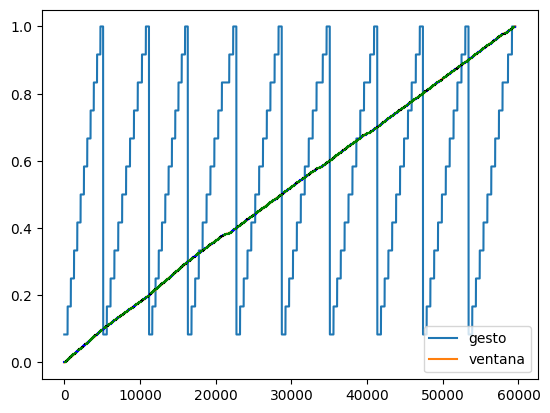

In [ ]:
# Quiero visualizar con diferentes colores las ventanas que van al train, val y test
ventanas_train = []
ventanas_val = []
ventanas_test = []

plt.figure()
plt.plot(label_gestos[:, 1]/np.max(label_gestos[:, 1]), label = 'gesto')
plt.plot(label_gestos[:, 0]/np.max(label_gestos[:, 0]), label = 'ventana')
for i in range(len(train)): #
    ventana_act_train = np.where(label_gestos[:, 0]==train[i])[0]
    ventanas_train.append(ventana_act_train)
    plt.plot(ventana_act_train, label_gestos[ventana_act_train, 0]/np.max(label_gestos[:, 0]), color = 'green')

    if i < len(val):   # val y test tienen menos datos
        ventana_act_val = np.where(label_gestos[:, 0]==val[i])[0]
        ventanas_val.append(ventana_act_val)
        plt.plot(ventana_act_val, label_gestos[ventana_act_val, 0]/np.max(label_gestos[:, 0]), color = 'blue')

        ventana_act_test = np.where(label_gestos[:, 0]==test[i])[0]
        ventanas_test.append(ventana_act_test)
        plt.plot(ventana_act_test, label_gestos[ventana_act_test, 0]/np.max(label_gestos[:, 0]), color = 'black')

plt.legend()

Procedo a armar los conjuntos de train, val y test para las ventanas con gesto.
Tengo identificada que repeticion va para cada conjunto, ahora identifico los indices de las features usando label.

In [ ]:
# Procedo a armar los conjuntos de train, val y test para las ventanas con gesto
# Tengo identificada que repeticion va para cada conjunto, ahora identifico los indices de las features usando label
indices_train = []
for j in range(len(train)):
    indices_train.extend(np.where(label[:, 0]==train[j])[0])

indices_val = []
indices_test = []
for j in range(len(val)):
    indices_val.extend(np.where(label[:, 0]==val[j])[0])
    indices_test.extend(np.where(label[:, 0]==test[j])[0])

In [ ]:
# Ahora agrego las ventanas de reposo

# Voy a fijarme a que conjunto fue la repeticion anterior (que es de un gesto que no es reposo), y mandar la repeticion de reposo para ese conjunto.

# Al igual que para los otros gestos, quiero mandar todas las features de una misma "repeticion" de reposo para el mismo conjunto
div_repe_reposo = np.where(np.diff(ind_reposo)!=1)[0]
div_repe_reposo = np.insert(div_repe_reposo, 0, -1)   # el -1 es porque todos me apuntan al ultimo elemento de cada repeticion, en el for le voy a sumar 1 a todos para que me apunten al inicio que es lo que me interesa

# Calculo cantidad de repeticiones de reposo
cant_repeticiones_reposo = len(div_repe_reposo)

pertenencia_conjuntos = []  # train, val, test. Cada dato solo puede pertenecer a 1 de estos conjuntos

for i in range(len(div_repe_reposo)):
    ind0_repe_reposo_act = ind_reposo[div_repe_reposo[i]+1]
    id_repe_act = label[ind0_repe_reposo_act, 0]
    id_repe_ant = label[ind0_repe_reposo_act-1, 0]

    # id de repeticio de reposo y a que conjunto mandarlo
    pertenencia_conjuntos.append([id_repe_act, id_repe_ant in train, id_repe_ant in val, id_repe_ant in test])

pertenencia_conjuntos = np.array(pertenencia_conjuntos)

id_reposo_train = pertenencia_conjuntos[np.where(pertenencia_conjuntos[:, 1])[0], 0]
id_reposo_val = pertenencia_conjuntos[np.where(pertenencia_conjuntos[:, 2])[0], 0]
id_reposo_test = pertenencia_conjuntos[np.where(pertenencia_conjuntos[:, 3])[0], 0]

for j in range(len(id_reposo_train)):
    indices_train.extend(np.where(label[:, 0]==id_reposo_train[j])[0])

for j in range(len(id_reposo_val)):
    indices_val.extend(np.where(label[:, 0]==id_reposo_val[j])[0])
    indices_test.extend(np.where(label[:, 0]==id_reposo_test[j])[0])



Habiendo calculado los índices, prosigo a armar los conjuntos, extrayendo las features y labels asociados a los índices calculados para cada conjunto de datos.

In [ ]:
# lo paso a numpy array para poder definir de forma mas comoda los conjuntos de train test y val
features = np.array(features)


X_train = features[indices_train, :]
y_train = label[indices_train, 1]
X_val = features[indices_val, :]
y_val = label[indices_val, 1]
X_test =  features[indices_test, :]
y_test = label[indices_test, 1]

Entreno una red neuronal de arquitectura 250-500-250.




In [ ]:
# Quiero calcular el tiempo que demora en entrenarse el algoritmo
start_time = time.time()

# Parametros de entrada de la red neuronal que tenemos que definir
# Definimos a mano la cantidad de features
featureNum = 15
chNum = 16
# Numero de columnas que va a haber en features
inputDim = chNum*featureNum
# Numero de gestos contando el reposo
clasNum = np.max(label[:, 1]) + 1

# Architecture 250 - 500 - 250
red = cl.Clasificador(model= "mlp", arch = [250,500,250], catNum = clasNum, featureNum = inputDim)
red.train(X_train, y_train, X_val, y_val)

end_time = time.time()
training_time = end_time - start_time

# Calculo las etiquetas predecidas por el modelo
y_pred = red.predict(X_test)


Voy a guardar el clasificador, y evaluar distintas métricas: accuracy, precision y recall. También voy a hacer una matriz de confusión.

335/335 [==============================] - 1s 1ms/step
Accuracy: 0.5760067270858638
Precision: 0.5944863781855868
Recall: 0.5760067270858638


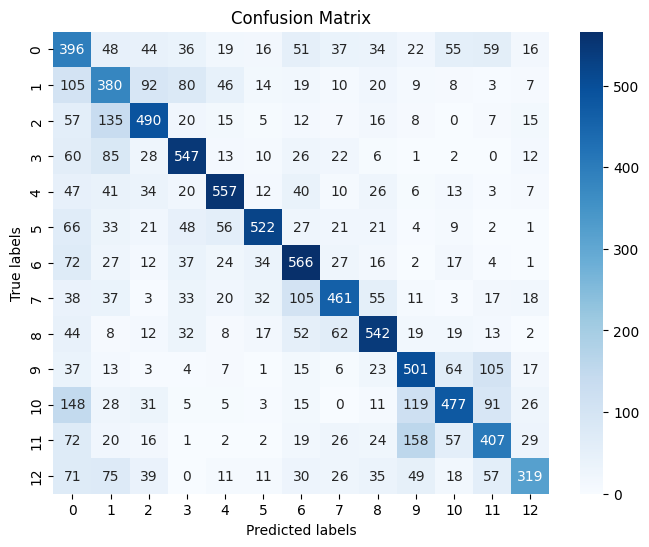

<Figure size 640x480 with 0 Axes>

In [ ]:
nombre = 'baseline_mlp_sep_rep_r1'

# Guardar el modelo entrenado en un archivo
joblib.dump(red, nombre + '.pkl')

# Predecir en el conjunto de test
y_pred = red.predict(X_test)

# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Guardar la imagen de la matriz de confusión
plt.savefig("confusion_matrix.png")

Voy a guardar las métricas calculadas en un experimento en Comet




In [ ]:
# Conectar con Comet
API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO' # Se puede encontrar en Settings(Arriba a la derecha en Comet)

# Crear un experimento con mi API KEY
exp = Experiment(api_key=API_KEY,
                 project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['baseline', 'mlp', 'sep_rep']) # Tags

exp.log_metric("accuracy", accuracy)
exp.log_metric("precision", precision)
exp.log_metric("recall", recall)
exp.log_metric("training_time", training_time)
exp.log_confusion_matrix(y_test, y_pred)
exp.log_parameter("ind_train", indices_train)
exp.log_parameter("ind_val", indices_val)
exp.log_parameter("ind_test", indices_test)
exp.log_text("Primeros dos sujetos --> test, tercero y cuarto --> validación, resto --> train. \n Corresponde a la primera ronda que entreno con estos parámetros. ")   # Comentario del experimento


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorboard, lightgbm, sklearn, keras, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/b0b4720059b442f0a0056480d7129b91



{'web': 'https://www.comet.com/api/asset/download?assetId=d89d956b284e42b3bc1c27f1de0ae65c&experimentKey=b0b4720059b442f0a0056480d7129b91',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=d89d956b284e42b3bc1c27f1de0ae65c&experimentKey=b0b4720059b442f0a0056480d7129b91',
 'assetId': 'd89d956b284e42b3bc1c27f1de0ae65c'}

In [ ]:
# Subir el modelo
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/b0b4720059b442f0a0056480d7129b91
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.5760067270858638
COMET INFO:     precision     : 0.5944863781855868
COMET INFO:     recall        : 0.5760067270858638
COMET INFO:     training_time : 444.914808511734
COMET INFO:   Others:
COMET INFO:     Name : renato_mlp_80_250_80_sep_rep_W200_I100
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (438.32 KB

Lo junto todo en un bloque para ejecutarlo de forma iterativa

In [4]:
%cd "/content/drive/My Drive/repo_tesis/archivos_generados_codigos"

/content/drive/My Drive/repo_tesis/archivos_generados_codigos


In [5]:
for k in range(1, 11):
  label = np.array(label)
  ind_reposo = np.where(label[:, 1]==0)[0]
  ind_gestos = np.where(label[:, 1]!=0)[0]
  label_gestos = label[ind_gestos, :]
  division_gestos = np.where(np.diff(label_gestos[:, 1])!=0)[0]
  division_id_ventanas = np.where(np.diff(label_gestos[:, 0])!=0)[0]
  train = []
  val = []
  test = []
  for i in range(len(division_gestos)+1):  #
      if i==len(division_gestos):
          ind_tope_ventana = np.max(label_gestos[:, 0])
          ind_inicio_ventana = label_gestos[division_gestos[-1], 0]
          cant_ventanas = ind_tope_ventana - ind_inicio_ventana
      else:
          tope = division_gestos[i]   # este es limite con el proximo gesto

          if i==0:
              inicio = 0
              ind_inicio_ventana = 0
          else:
              inicio = division_gestos[i-1]
              ind_inicio_ventana = np.where(division_id_ventanas==inicio)[0][0]
          ind_tope_ventana = np.where(division_id_ventanas==tope)[0][0]
          cant_ventanas = ind_tope_ventana - ind_inicio_ventana
      if i != 0:
          sorteo = np.random.permutation(cant_ventanas)
          sorteo += 1     # correccion de rango
      else:
          sorteo = np.random.permutation(cant_ventanas+1)
      test.append(ind_inicio_ventana + sorteo[0])
      val.append(ind_inicio_ventana + sorteo[1])
      for j in range(2, len(sorteo)):
          train.append(ind_inicio_ventana + sorteo[j])
  indices_train = []
  for j in range(len(train)):
      indices_train.extend(np.where(label[:, 0]==train[j])[0])

  indices_val = []
  indices_test = []
  for j in range(len(val)):
      indices_val.extend(np.where(label[:, 0]==val[j])[0])
      indices_test.extend(np.where(label[:, 0]==test[j])[0])
  div_repe_reposo = np.where(np.diff(ind_reposo)!=1)[0]
  div_repe_reposo = np.insert(div_repe_reposo, 0, -1)   # el -1 es porque todos me apuntan al ultimo elemento de cada repeticion, en el for le voy a sumar 1 a todos para que me apunten al inicio que es lo que me interesa

  # Calculo cantidad de repeticiones de reposo
  cant_repeticiones_reposo = len(div_repe_reposo)

  pertenencia_conjuntos = []  # train, val, test. Cada dato solo puede pertenecer a 1 de estos conjuntos

  for i in range(len(div_repe_reposo)):
      ind0_repe_reposo_act = ind_reposo[div_repe_reposo[i]+1]
      id_repe_act = label[ind0_repe_reposo_act, 0]
      id_repe_ant = label[ind0_repe_reposo_act-1, 0]

      pertenencia_conjuntos.append([id_repe_act, id_repe_ant in train, id_repe_ant in val, id_repe_ant in test])

  pertenencia_conjuntos = np.array(pertenencia_conjuntos)

  id_reposo_train = pertenencia_conjuntos[np.where(pertenencia_conjuntos[:, 1])[0], 0]
  id_reposo_val = pertenencia_conjuntos[np.where(pertenencia_conjuntos[:, 2])[0], 0]
  id_reposo_test = pertenencia_conjuntos[np.where(pertenencia_conjuntos[:, 3])[0], 0]

  for j in range(len(id_reposo_train)):
      indices_train.extend(np.where(label[:, 0]==id_reposo_train[j])[0])

  for j in range(len(id_reposo_val)):
      indices_val.extend(np.where(label[:, 0]==id_reposo_val[j])[0])
      indices_test.extend(np.where(label[:, 0]==id_reposo_test[j])[0])
  joblib.dump(indices_train, 'indices_train_' + str(k) + '.pkl')
  joblib.dump(indices_val, 'indices_val_' + str(k) + '.pkl')
  joblib.dump(indices_test, 'indices_test_' + str(k) + '.pkl')

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/archivos_generados_codigos"
for k in range(1, 2):
  features = np.array(features)
  label = np.array(label)

  indices_train = load('indices_train_' + str(k) + '.pkl')
  #X_train = features[indices_train, :]
  #y_train = label[indices_train, 1]
  #del(indices_train)

  indices_val = load('indices_val_' + str(k) + '.pkl')
  #X_val = features[indices_val, :]
  #y_val = label[indices_val, 1]
  #del(indices_val)

  indices_test = load('indices_test_' + str(k) + '.pkl')
  #X_test =  features[indices_test, :]
  #y_test = label[indices_test, 1]
  #del(indices_test)

  start_time = time.time()

  featureNum = 15
  chNum = 16
  inputDim = chNum*featureNum
  clasNum = np.max(label[:, 1]) + 1

  # Borrar todo lo que no use de aqui para adelante en este punto

  # Architecture 250 - 500 - 250
  red = cl.Clasificador(model= "mlp", arch = [250,500,250], catNum = clasNum, featureNum = inputDim)
  red.train(features[indices_train, :], label[indices_train, 1], features[indices_val, :], label[indices_val, 1])

  end_time = time.time()
  training_time = end_time - start_time
  y_pred = red.predict(X_test)

  nombre = 'baseline_mlp_sep_rep_r'+str(k)

  joblib.dump(red, nombre + '.pkl')
  y_pred = red.predict(features[indices_test, :])
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(label[indices_test, 1], y_pred, average='weighted')
  conf_matrix = confusion_matrix(label[indices_test, 1], y_pred)
  plt.savefig("confusion_matrix.png")

  # Conectar con Comet
  API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO' # Se puede encontrar en Settings(Arriba a la derecha en Comet)
  exp = Experiment(api_key=API_KEY,
                  project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                  auto_param_logging=False)
  exp.set_name(nombre) # Nombre de este experimento
  exp.add_tags(['baseline', 'mlp', 'sep_rep']) # Tags

  exp.log_metric("accuracy", accuracy)
  exp.log_metric("precision", precision)
  exp.log_metric("recall", recall)
  exp.log_metric("training_time", training_time)
  exp.log_confusion_matrix(label[indices_test, 1], y_pred)
  exp.log_parameter("ind_train", indices_train)
  exp.log_parameter("ind_val", indices_val)
  exp.log_parameter("ind_test", indices_test)
  exp.log_text("Experimento separando los datos por repeticiones y usando MLP. En cuanto a las ventanas: W=200, I=50.")   # Comentario del experimento

/content/drive/My Drive/repo_tesis/archivos_generados_codigos
